# Info from Kaggle

Data Fields
* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

AdoptionSpeed

Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:
* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

# Setting up the Environment

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from category_encoders import LeaveOneOutEncoder


from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

## Adam's generously provided functions

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


def one_hot_encode(X, encode_cols, index=None):
    other_cols = [c for c in X.columns if c not in encode_cols]

    ct = ColumnTransformer(
        #   Format
        #   [("name of step", what_to_do(), [what columns to do it to])]
        [
            (
                "one hot encode",
                OneHotEncoder(drop="first", categories="auto", sparse=False),
                encode_cols,
            )
        ],
        remainder="passthrough",
    )

    ct.fit(X)

    # This is not the flexible and definitely not the most
    # readable way to get column names, a function would be better
    encoded_names = ct.transformers_[0][1].get_feature_names()
    encoded_names = list(encoded_names)

    X_encoded = ct.transform(X)
    X_encoded = pd.DataFrame(X_encoded, columns=encoded_names + other_cols, index=index)

    for i, name in enumerate(encode_cols):
        X_encoded.columns = X_encoded.columns.str.replace(f"^x{i}", name)

    return X_encoded


def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

<IPython.core.display.Javascript object>

## From the Reading

In [4]:
def plot_confusion_matrix(
    cm, target_names, title="Confusion matrix", cmap=None, normalize=True
):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(
                j,
                i,
                "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )
        else:
            plt.text(
                j,
                i,
                "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.ylabel("Predicted label")
    plt.xlabel(
        "True label\naccuracy={:0.4f}; misclass={:0.4f}".format(accuracy, misclass)
    )
    plt.show()

<IPython.core.display.Javascript object>

# Reading in the Data

In [5]:
breed_labels_df = pd.read_csv("breed_labels.csv")

<IPython.core.display.Javascript object>

In [6]:
breed_labels_df.tail()

,BreedID,Type,BreedName
302,302,2,Torbie
303,303,2,Tortoiseshell
304,304,2,Turkish Angora
305,305,2,Turkish Van
306,306,2,Tuxedo


<IPython.core.display.Javascript object>

In [7]:
color_labels_df = pd.read_csv("color_labels.csv")

<IPython.core.display.Javascript object>

In [8]:
color_labels_df.head(20)

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream
5,6,Gray
6,7,White


<IPython.core.display.Javascript object>

In [9]:
state_labels_df = pd.read_csv("state_labels.csv")

<IPython.core.display.Javascript object>

In [10]:
state_labels_df.head(20)

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan
5,41324,Melaka
6,41332,Negeri Sembilan
7,41335,Pahang
8,41330,Perak
9,41380,Perlis


<IPython.core.display.Javascript object>

In [11]:
df = pd.read_csv("train/train.csv")

<IPython.core.display.Javascript object>

In [12]:
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


<IPython.core.display.Javascript object>

## Missing values

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

<IPython.core.display.Javascript object>

Looks like `Name` and `Description` have some missingness.  Not too worried about these, so let's deal with them as we come to them.

Now let's go through each of the variables to understand the data better, and get a sense for whether they correlate with our target, `AdoptionSpeed`.

# Data Cleaning and Univariate Analysis

### Type

1 is dog, 2 is cat.

In [14]:
df["Type"].value_counts()

1    8132
2    6861
Name: Type, dtype: int64

<IPython.core.display.Javascript object>

Let's make "Type" into a zero or a 1 for convention's sake

In [15]:
df["Type"] = df["Type"] - 1

<IPython.core.display.Javascript object>

In [16]:
df["Type"].value_counts()

0    8132
1    6861
Name: Type, dtype: int64

<IPython.core.display.Javascript object>

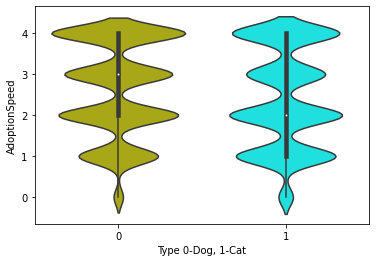

<IPython.core.display.Javascript object>

In [17]:
sns.violinplot(x="Type", y="AdoptionSpeed", palette=["y", "cyan"], data=df)
plt.xlabel("Type 0-Dog, 1-Cat")
plt.show()

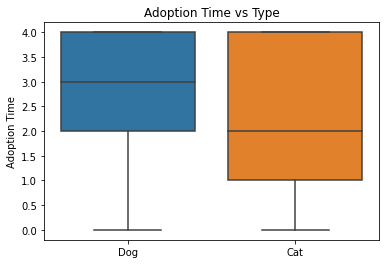

<IPython.core.display.Javascript object>

In [18]:
sns.boxplot("Type", "AdoptionSpeed", data=df)
plt.ylabel("Adoption Time")
plt.xlabel("")
plt.xticks([0, 1], labels=["Dog", "Cat"])
plt.title("Adoption Time vs Type")
# plt.show()
plt.savefig("type_vs_AdoptSpeed.png", dpi=1000)

In [19]:
from scipy.stats import mannwhitneyu

<IPython.core.display.Javascript object>

In [20]:
cats_df = df[df["Type"] == 1]
dogs_df = df[df["Type"] == 0]
cats_adoptionspeeds = np.array(cats_df["AdoptionSpeed"])
dogs_adoptionspeeds = np.array(dogs_df["AdoptionSpeed"])

_, p = mannwhitneyu(cats_adoptionspeeds, dogs_adoptionspeeds)
p

2.042951671218515e-28

<IPython.core.display.Javascript object>

### Name

Missing some names, let's investigate...

Are they MAR?

In [21]:
df[df["Name"].isna().sort_values(ascending=False)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
5,1,NaN,3,266,0,2,5,6,0,2,...,1,1,0,41326,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,2
8,1,NaN,2,265,0,2,6,0,0,2,...,1,1,0,41326,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,1
19,1,NaN,1,266,0,3,1,2,7,1,...,1,5,0,41326,b752f78276215f44581eeb6eea1e63bc,0,"Birth Date: Oct 30th Kitty 1, Melly -Female Sa...",b10e7605a,1.0,4
33,1,NaN,4,266,0,2,1,6,7,1,...,1,2,0,41326,7d58438884ab468dce87c7e252bbd6e4,0,Two gorgeous kittens have just lost their mumm...,9415bc79e,7.0,3
36,1,NaN,24,265,292,2,1,4,0,2,...,1,3,0,41326,90b00f90ffdf9ec1cac529a2bbef3ecc,0,she fat n healthy. in door cat,61fa73996,2.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14871,0,NaN,2,307,0,2,4,7,0,2,...,1,1,0,41324,c8ea0bc42e630c72747986c4c0ce36aa,0,mixed breed. interested please kindly email me,5aff9022b,1.0,4
14930,0,NaN,12,307,307,1,2,7,0,2,...,1,1,0,41401,5c4ddaeafcbdfca6d291c6d010f1c35c,0,Friendly and loyal mongrel looking for a home....,1f70f8112,3.0,1
14935,1,NaN,1,243,0,3,2,3,4,2,...,1,2,0,41336,8d3049f2bb476520449863435ad067ec,0,the 2 kittens follow my friend into our house(...,811b66c3e,5.0,1
14984,0,NaN,60,307,0,2,2,5,0,2,...,1,1,0,41324,c8ea0bc42e630c72747986c4c0ce36aa,0,"abandoned,but healthy",f5dc70d35,1.0,4


<IPython.core.display.Javascript object>

What kind of names do we have? First, let's transform this to lowercase so we don't have any issues with string matching...

In [22]:
df["Name"] = df["Name"].str.lower()

df["Name"].value_counts()

baby                       67
lucky                      66
mimi                       59
brownie                    55
no name                    55
                           ..
buttermilk                  1
mummy and three kittens     1
4 stray kittens             1
1 puppy for adoption        1
sven                        1
Name: Name, Length: 8846, dtype: int64

<IPython.core.display.Javascript object>

Looks like we have several "names" that aren't really names (No Name, No Name Yet, Kitty, Kittens, Kitten, Puppy, Puppies, etc.).  We also have some that are null.  

Strategy: Let's make all of these the same "no name" value. 

In [23]:
df["Name"] = df["Name"].fillna("no name")

no_name_list = [
    "puppy",
    "puppies",
    "dog",
    "kitten",
    "kitty",
    "kitties",
    "kittens",
    "cat",
    "no name",
    "no name yet",
]


names = df["Name"]
no_names = []

for name in names:
    if name in no_name_list:
        no_names.append("no name")
    else:
        no_names.append(name)

df["Name"] = no_names

<IPython.core.display.Javascript object>

In [24]:
has_names = []
names = df["Name"]

for name in names:
    if name == "no name":
        has_names.append(0)
    else:
        has_names.append(1)

df["has_name"] = has_names

<IPython.core.display.Javascript object>

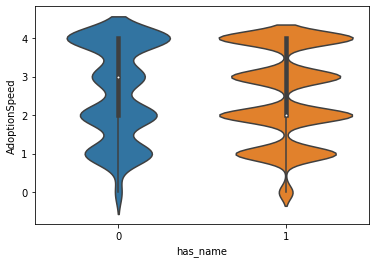

<IPython.core.display.Javascript object>

In [25]:
sns.violinplot(x="has_name", y="AdoptionSpeed", data=df)
plt.show()

TODO: Investigage why are adoption speeds more discretely distributed for animals with names?

### Age

In [26]:
df["Age"].describe()

count    14993.000000
mean        10.452078
std         18.155790
min          0.000000
25%          2.000000
50%          3.000000
75%         12.000000
max        255.000000
Name: Age, dtype: float64

<IPython.core.display.Javascript object>

In [27]:
df["Age"].value_counts().head(24)

2     3503
1     2304
3     1966
4     1109
12     967
24     651
5      595
6      558
36     417
8      309
7      281
48     241
60     199
9      184
0      179
18     165
10     162
72     104
84     102
11      94
15      79
14      76
17      67
30      52
Name: Age, dtype: int64

<IPython.core.display.Javascript object>

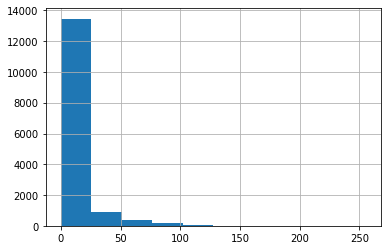

<IPython.core.display.Javascript object>

In [28]:
df["Age"].hist()
plt.show()

Very right-skewed distribution...let's log transform it using the Yeo-Johnson transformation.

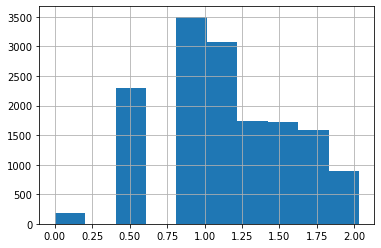

<IPython.core.display.Javascript object>

In [29]:
age = df["Age"].to_numpy() + 1

df["age_t"], _ = stats.boxcox(age)

df["age_t"].hist()
plt.show()

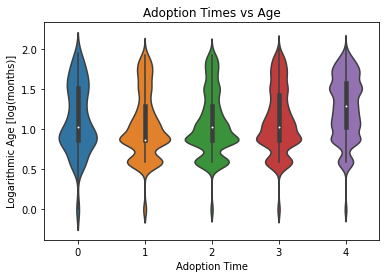

<IPython.core.display.Javascript object>

In [30]:
sns.violinplot("AdoptionSpeed", "age_t", data=df)
plt.ylabel("Logarithmic Age [log(months)]")
plt.xlabel("Adoption Time")
plt.title("Adoption Times vs Age")
plt.show()
# plt.savefig("Age_vs_AdoptSpeed.png", dpi=1000)

### Breed1 and Breed2

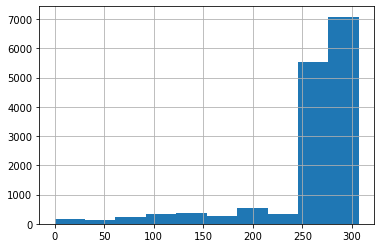

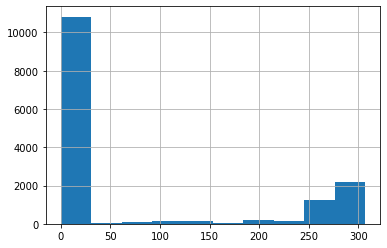

<IPython.core.display.Javascript object>

In [31]:
df["Breed1"].hist()
plt.show()

df["Breed2"].hist()
plt.show()

Because there are so many breeds and major class imbalance, let's simplify and try to create an is_pure_bred feature.  We exclude mixed breed, no breed identified, and generic breeds like domestic short hair.

In [32]:
is_pure_bred = []

breed1 = np.array(df["Breed1"])
breed2 = np.array(df["Breed2"])

excluded_breed_codes = [0, 307, 264, 265, 266]

for i in range(0, len(breed1)):
    if breed1[i] not in excluded_breed_codes and breed2[i] == 0:
        is_pure_bred.append(1)
    else:
        is_pure_bred.append(0)

df["is_pure_bred"] = is_pure_bred

<IPython.core.display.Javascript object>

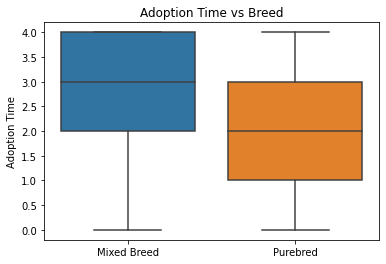

<IPython.core.display.Javascript object>

In [33]:
sns.boxplot("is_pure_bred", "AdoptionSpeed", data=df)
plt.ylabel("Adoption Time")
plt.xlabel("")
plt.xticks([0, 1], labels=["Mixed Breed", "Purebred"])
plt.title("Adoption Time vs Breed")
# plt.show()
plt.savefig("breed_vs_AdoptSpeed.png", dpi=1000)

In [34]:
mixed_df = df[df["is_pure_bred"] == 0]
pure_df = df[df["is_pure_bred"] == 1]
mixed_adoptionspeeds = np.array(mixed_df["AdoptionSpeed"])
pure_adoptionspeeds = np.array(pure_df["AdoptionSpeed"])

_, p = mannwhitneyu(mixed_adoptionspeeds, pure_adoptionspeeds)
p

4.7569708331712775e-24

<IPython.core.display.Javascript object>

### Gender

1 - Male, 2 - Female, 3 - mixed (group of animals)

In [35]:
df["Gender"].value_counts()

2    7277
1    5536
3    2180
Name: Gender, dtype: int64

<IPython.core.display.Javascript object>

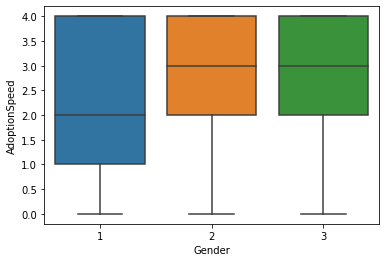

<IPython.core.display.Javascript object>

In [36]:
sns.boxplot(x="Gender", y="AdoptionSpeed", data=df)
plt.show()

### Color1, Color2, and Color3

In [37]:
print("Color1:")
display(df["Color1"].value_counts())

print("Color2:")
display(df["Color2"].value_counts())

print("Color3:")
display(df["Color3"].value_counts())

Color1:


1    7427
2    3750
3     947
5     884
6     684
7     667
4     634
Name: Color1, dtype: int64

Color2:


0    4471
7    3438
2    3313
5    1128
6    1063
4     870
3     710
Name: Color2, dtype: int64

Color3:


0    10604
7     3221
5      417
6      378
4      198
3      175
Name: Color3, dtype: int64

<IPython.core.display.Javascript object>

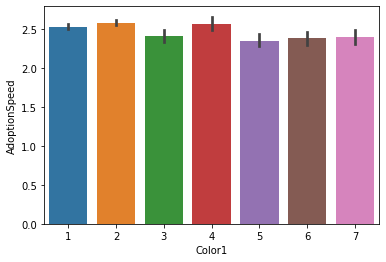

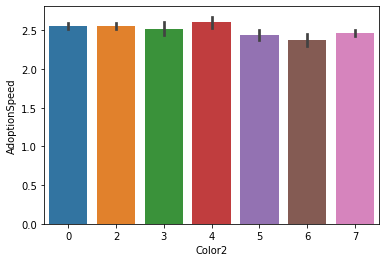

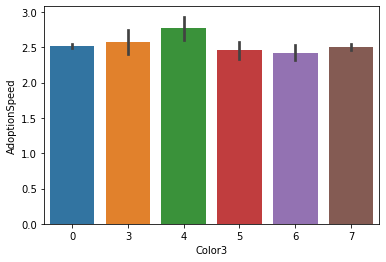

<IPython.core.display.Javascript object>

In [38]:
sns.barplot(x="Color1", y="AdoptionSpeed", data=df)
plt.show()

sns.barplot(x="Color2", y="AdoptionSpeed", data=df)
plt.show()

sns.barplot(x="Color3", y="AdoptionSpeed", data=df)
plt.show()

Seems like Color2 and Color3 have a zero category, which must mean that the animal has no second or third color.

In my experience, black dogs and cats are adopted less often than other colorings.  I'm curious if this is true in this dataset too.

Let's create a feature, `is_black`, that will be 1 if the dog/cat has Color1 that's black and Color2 and Color3 of 0, and 0 otherwise.

In [39]:
is_black = []

for i in range(0, len(df["Color1"])):
    if df["Color1"][i] == 1 and df["Color2"][i] == 0 and df["Color3"][i] == 0:
        is_black.append(1)
    else:
        is_black.append(0)

df["is_black"] = is_black

<IPython.core.display.Javascript object>

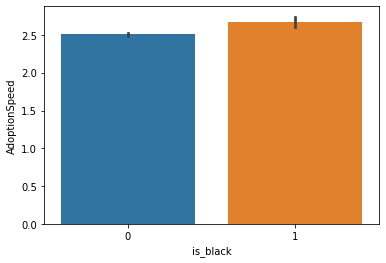

<IPython.core.display.Javascript object>

In [40]:
sns.barplot(x="is_black", y="AdoptionSpeed", data=df)
plt.show()

### MaturitySize

In [41]:
df["MaturitySize"].value_counts()

2    10305
1     3395
3     1260
4       33
Name: MaturitySize, dtype: int64

<IPython.core.display.Javascript object>

Combine 4's into threes for a combined large and extra-large category.

In [42]:
new_maturity_size = []
maturity_size = df["MaturitySize"]

for size in maturity_size:
    if size == 4:
        new_maturity_size.append(3)
    else:
        new_maturity_size.append(size)

df["maturity_size"] = new_maturity_size

<IPython.core.display.Javascript object>

In [43]:
df["maturity_size"].value_counts()

2    10305
1     3395
3     1293
Name: maturity_size, dtype: int64

<IPython.core.display.Javascript object>

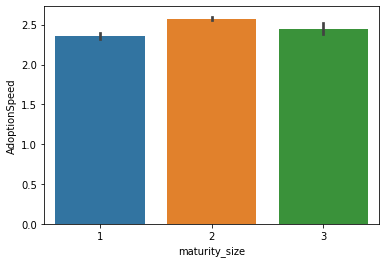

<IPython.core.display.Javascript object>

In [44]:
sns.barplot(x="maturity_size", y="AdoptionSpeed", data=df)
plt.show()

### FurLength

In [45]:
df["FurLength"].value_counts()

1    8808
2    5361
3     824
Name: FurLength, dtype: int64

<IPython.core.display.Javascript object>

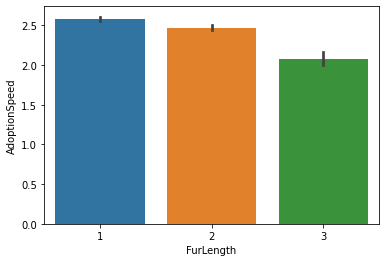

<IPython.core.display.Javascript object>

In [46]:
sns.barplot(x="FurLength", y="AdoptionSpeed", data=df)
plt.show()

### Vaccinated 

In [47]:
df["Vaccinated"].value_counts()

2    7227
1    5898
3    1868
Name: Vaccinated, dtype: int64

<IPython.core.display.Javascript object>

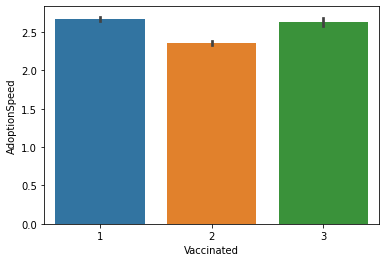

<IPython.core.display.Javascript object>

In [48]:
sns.barplot(x="Vaccinated", y="AdoptionSpeed", data=df)
plt.show()

### Dewormed

In [49]:
df["Dewormed"].value_counts()

1    8397
2    4815
3    1781
Name: Dewormed, dtype: int64

<IPython.core.display.Javascript object>

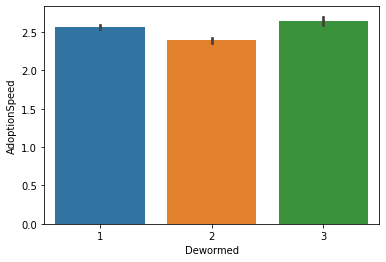

<IPython.core.display.Javascript object>

In [50]:
sns.barplot(x="Dewormed", y="AdoptionSpeed", data=df)
plt.show()

### Sterilized

In [51]:
df["Sterilized"].value_counts()

2    10077
1     3101
3     1815
Name: Sterilized, dtype: int64

<IPython.core.display.Javascript object>

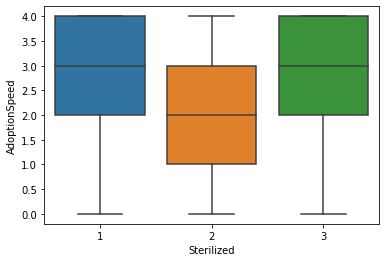

<IPython.core.display.Javascript object>

In [52]:
sns.boxplot(x="Sterilized", y="AdoptionSpeed", data=df)
plt.show()

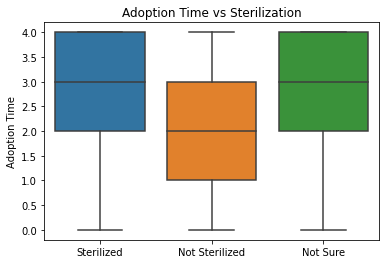

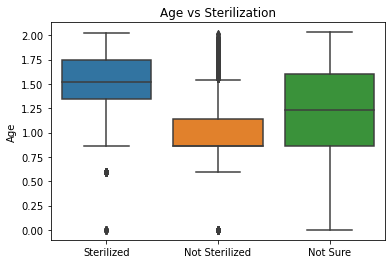

<IPython.core.display.Javascript object>

In [53]:
sns.boxplot(x="Sterilized", y="AdoptionSpeed", data=df)
plt.ylabel("Adoption Time")
plt.xlabel("")
plt.xticks([0, 1, 2], labels=["Sterilized", "Not Sterilized", "Not Sure"])
plt.title("Adoption Time vs Sterilization")
plt.show()
# plt.savefig("ster_vs_AdoptSpeed.png", dpi=1000)

sns.boxplot(x="Sterilized", y="age_t", data=df)
plt.ylabel("Age")
plt.xlabel("")
plt.xticks([0, 1, 2], labels=["Sterilized", "Not Sterilized", "Not Sure"])
plt.title("Age vs Sterilization")
# plt.show()
plt.savefig("age_vs_ster.png", dpi=1000)

In [54]:
ster_df = df[df["Sterilized"] == 0]
notster_df = df[df["Sterilized"] == 1]
ster_adoptionspeeds = np.array(ster_df["AdoptionSpeed"])
notster_adoptionspeeds = np.array(notster_df["AdoptionSpeed"])

_, p = mannwhitneyu(ster_adoptionspeeds, notster_adoptionspeeds)
p

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


0.0

<IPython.core.display.Javascript object>

Interesting that more are not sterilized than are, but the adoption speed is less for non-sterilized animals, though I'm guessing this a function of age.

#TODO: tease out the relationship between age and sterilized, vaccinated, and dewormed.

Also, the sterilized, vaccinated, and dewormed categories look collinear.  I'm guessing a dog or cat that has been sterilized must have already been dewormed and vaccinated.

### Health

In [55]:
df["Health"].value_counts()

1    14478
2      481
3       34
Name: Health, dtype: int64

<IPython.core.display.Javascript object>

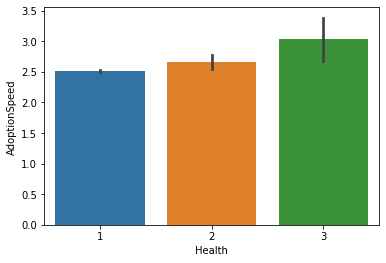

<IPython.core.display.Javascript object>

In [56]:
sns.barplot(x="Health", y="AdoptionSpeed", data=df)
plt.show()

Combining 2s and 3s into an "is_injured" category.

In [57]:
is_injured = []

for i in range(0, len(df["Health"])):
    if df["Health"][i] >= 2:
        is_injured.append(1)
    else:
        is_injured.append(0)

df["is_injured"] = is_injured

<IPython.core.display.Javascript object>

In [58]:
df["is_injured"].value_counts()

0    14478
1      515
Name: is_injured, dtype: int64

<IPython.core.display.Javascript object>

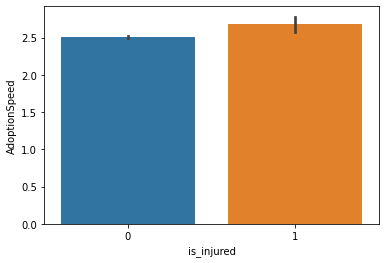

<IPython.core.display.Javascript object>

In [59]:
sns.barplot(x="is_injured", y="AdoptionSpeed", data=df)
plt.show()

### Quantity

In [60]:
df["Quantity"].value_counts()

1     11565
2      1422
3       726
4       531
5       333
6       185
7        84
8        52
9        33
10       19
20       12
11       10
12        6
15        4
17        3
16        3
13        2
14        2
18        1
Name: Quantity, dtype: int64

<IPython.core.display.Javascript object>

Combining all quantities greater than 4 into a 5-and-up category...

In [61]:
new_quant = []

for quant in df["Quantity"]:
    if quant > 4:
        new_quant.append(5)
    else:
        new_quant.append(quant)

df["1_5_quantity"] = new_quant

<IPython.core.display.Javascript object>

In [62]:
df["1_5_quantity"].value_counts()

1    11565
2     1422
5      749
3      726
4      531
Name: 1_5_quantity, dtype: int64

<IPython.core.display.Javascript object>

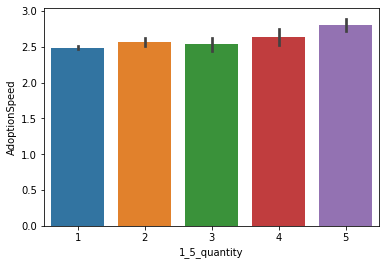

<IPython.core.display.Javascript object>

In [63]:
sns.barplot(x="1_5_quantity", y="AdoptionSpeed", data=df)
plt.show()

Let's see if throwing out all of the records with more than 1 adoptable animal helps our model...

In [64]:
# df = df[df["Quantity"] == 1]

<IPython.core.display.Javascript object>

### Fee

In [65]:
df["Fee"].value_counts().head(10)

0      12663
50       468
100      408
200      219
150      162
20       136
300      120
30       103
250       92
1         82
Name: Fee, dtype: int64

<IPython.core.display.Javascript object>

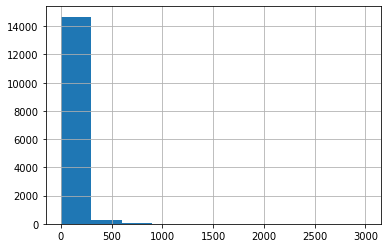

<IPython.core.display.Javascript object>

In [66]:
df["Fee"].hist()
plt.show()

Another very right-skewed distribution...Let's try transforming this like we did with age...

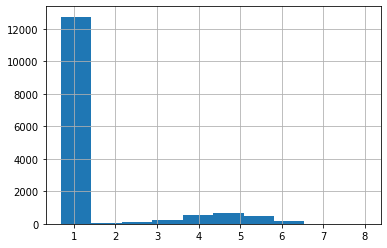

<IPython.core.display.Javascript object>

In [67]:
fee = df["Fee"].to_numpy() + 1
df["fee_t"] = np.log(fee + 1)

df["fee_t"].hist()
plt.show()

Ew, that transformation didn't work.  Let's just try creating binary is_free column.

In [68]:
is_free = []
fees = df["Fee"]

for fee in fees:
    if fee == 0:
        is_free.append(1)
    else:
        is_free.append(0)

df["is_free"] = is_free
df["is_free"].value_counts()

1    12663
0     2330
Name: is_free, dtype: int64

<IPython.core.display.Javascript object>

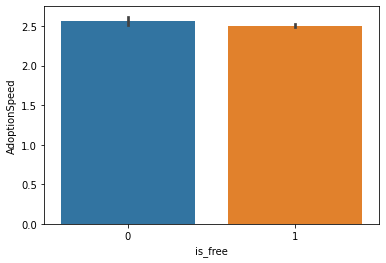

<IPython.core.display.Javascript object>

In [69]:
sns.barplot(x="is_free", y="AdoptionSpeed", data=df)
plt.show()

### State

Will one-hot-encode this feature.

### RescuerID

In [70]:
df["RescuerID"].value_counts().head(10)

fa90fa5b1ee11c86938398b60abc32cb    459
aa66486163b6cbc25ea62a34b11c9b91    315
c00756f2bdd8fa88fc9f07a8309f7d5d    231
b53c34474d9e24574bcec6a3d3306a0d    228
ee2747ce26468ec44c7194e7d1d9dad9    156
95481e953f8aed9ec3d16fc4509537e8    134
b770bac0ca797cf1433c48a35d30c4cb    111
a042471e0f43f2cf707104a1a138a7df     95
fd970cc91d06d82eebf046340137b272     93
7ed6d84e2e6879245e55447aee39c328     85
Name: RescuerID, dtype: int64

<IPython.core.display.Javascript object>

Creating an "is_top_10_rescue" column that flags whether pet is from a rescue that has some of the most entries.

In [71]:
id_list = list(df["RescuerID"].value_counts().index)
top_10_rescues = id_list[0:10]

rescue_col = df["RescuerID"]
new_rescues_arr = []

for rescue in rescue_col:
    if rescue in top_10_rescues:
        new_rescues_arr.append(1)
    else:
        new_rescues_arr.append(0)

df["is_top_10_rescue"] = new_rescues_arr

<IPython.core.display.Javascript object>

In [72]:
df["is_top_10_rescue"].value_counts().head()

0    13086
1     1907
Name: is_top_10_rescue, dtype: int64

<IPython.core.display.Javascript object>

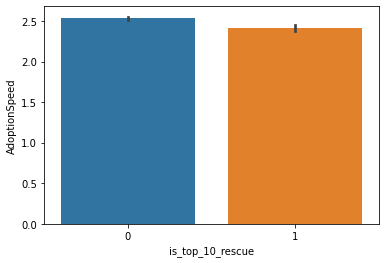

<IPython.core.display.Javascript object>

In [73]:
sns.barplot(x="is_top_10_rescue", y="AdoptionSpeed", data=df)
plt.show()

### VideoAmt

In [74]:
df["VideoAmt"].value_counts().head(20)

0    14419
1      417
2       92
3       36
4       15
5        7
6        4
8        2
7        1
Name: VideoAmt, dtype: int64

<IPython.core.display.Javascript object>

Let's make this binary, aka has_video: 1-yes, 0-no.

In [75]:
is_videoed = []
video_amts = df["VideoAmt"]
for video_amt in video_amts:
    if video_amt >= 1:
        is_videoed.append(1)
    else:
        is_videoed.append(0)

df["is_videoed"] = is_videoed

<IPython.core.display.Javascript object>

In [76]:
df["is_videoed"].value_counts()

0    14419
1      574
Name: is_videoed, dtype: int64

<IPython.core.display.Javascript object>

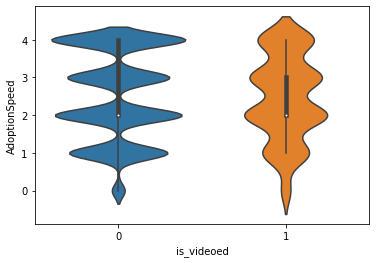

<IPython.core.display.Javascript object>

In [77]:
sns.violinplot(x="is_videoed", y="AdoptionSpeed", data=df)
plt.show()

### Description

In [78]:
df["Description"].value_counts().head()

For Adoption                               164
Dog 4 Adoption                              54
Cat for adoption                            25
Friendly                                    20
Please feel free to contact us : Stuart     18
Name: Description, dtype: int64

<IPython.core.display.Javascript object>

Dropping this column altogether.  NLP is beyond the scope of this study.

In [79]:
df = df.drop(columns=["Description"])

<IPython.core.display.Javascript object>

### PetID

In [80]:
df["PetID"].value_counts().head(20)

cd81fa60a    1
47787f847    1
cfe66604e    1
95a89f5f2    1
caa616482    1
700de2c49    1
7b7b7b71e    1
fa07f7477    1
32bc0b4fa    1
cae5c7ef1    1
ce50f376f    1
c7575df7b    1
fabc9bfec    1
3fe9fc6d9    1
5145c1766    1
59047a5a1    1
13be42d0e    1
28e14ee81    1
198357b7e    1
a684871b0    1
Name: PetID, dtype: int64

<IPython.core.display.Javascript object>

These are unique for each record.  Will drop from dataset and just use a generic index instead...

In [81]:
df = df.drop(columns=["PetID"])

<IPython.core.display.Javascript object>

### PhotoAmt

In [82]:
df["PhotoAmt"].value_counts().head(20)

1.0     3075
2.0     2518
3.0     2511
5.0     2147
4.0     1881
6.0      621
7.0      432
0.0      341
8.0      314
9.0      231
10.0     190
11.0     184
12.0      97
13.0      86
14.0      78
15.0      50
16.0      39
17.0      27
20.0      25
19.0      20
Name: PhotoAmt, dtype: int64

<IPython.core.display.Javascript object>

Combining all quantities of photos into a has_photo binary.

In [83]:
has_photo = []

photo_amts = df["PhotoAmt"]

for photo_amt in photo_amts:
    if photo_amt == 0:
        has_photo.append(0)
    else:
        has_photo.append(1)

df["has_photo"] = has_photo

<IPython.core.display.Javascript object>

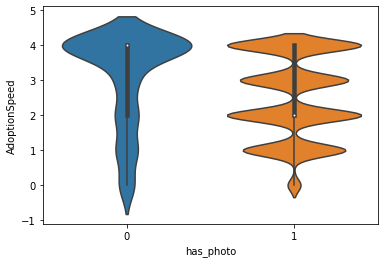

<IPython.core.display.Javascript object>

In [84]:
sns.violinplot(x="has_photo", y="AdoptionSpeed", data=df)
plt.show()

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 34 columns):
Type                14993 non-null int64
Name                14993 non-null object
Age                 14993 non-null int64
Breed1              14993 non-null int64
Breed2              14993 non-null int64
Gender              14993 non-null int64
Color1              14993 non-null int64
Color2              14993 non-null int64
Color3              14993 non-null int64
MaturitySize        14993 non-null int64
FurLength           14993 non-null int64
Vaccinated          14993 non-null int64
Dewormed            14993 non-null int64
Sterilized          14993 non-null int64
Health              14993 non-null int64
Quantity            14993 non-null int64
Fee                 14993 non-null int64
State               14993 non-null int64
RescuerID           14993 non-null object
VideoAmt            14993 non-null int64
PhotoAmt            14993 non-null float64
AdoptionSpeed       14993 

<IPython.core.display.Javascript object>

### AdoptionSpeed (Target)

In [86]:
df["AdoptionSpeed"].value_counts()

4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64

<IPython.core.display.Javascript object>

# Modeling - Linear Regression

In [87]:
# dropping unnecessary or redundant columns
df_lr = df.drop(
    columns=[
        "Name",
        "Age",
        "Breed1",
        "Breed2",
        "Color1",
        "Color2",
        "Color3",
        "MaturitySize",
        "Health",
        "Quantity",
        "Fee",
        "fee_t",
        "VideoAmt",
        "PhotoAmt",
        "RescuerID",
        "State",
    ]
)

# categorical variables that need encoding
cat_columns = [
    "Gender",
    "Vaccinated",
    "Dewormed",
    "FurLength",
    "Sterilized",
    "maturity_size",
    "1_5_quantity",
]

# one-hot encode the categorical columns
dummy_df = one_hot_encode(df_lr, encode_cols=cat_columns, index=df.index)

# check to make sure it worked...can't be too careful!
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 27 columns):
Gender_2            14993 non-null float64
Gender_3            14993 non-null float64
Vaccinated_2        14993 non-null float64
Vaccinated_3        14993 non-null float64
Dewormed_2          14993 non-null float64
Dewormed_3          14993 non-null float64
FurLength_2         14993 non-null float64
FurLength_3         14993 non-null float64
Sterilized_2        14993 non-null float64
Sterilized_3        14993 non-null float64
maturity_size_2     14993 non-null float64
maturity_size_3     14993 non-null float64
1_5_quantity_2      14993 non-null float64
1_5_quantity_3      14993 non-null float64
1_5_quantity_4      14993 non-null float64
1_5_quantity_5      14993 non-null float64
Type                14993 non-null float64
AdoptionSpeed       14993 non-null float64
has_name            14993 non-null float64
age_t               14993 non-null float64
is_pure_bred        14993 non-n

<IPython.core.display.Javascript object>

In [88]:
# define X and y

X = dummy_df.drop(columns=["AdoptionSpeed"])
y = dummy_df["AdoptionSpeed"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

In [89]:
# multicollinearity check
print_vif(X_train)

VIF results
-------------------------------
const               94.580962
Gender_2             1.215601
Gender_3             2.896299
Vaccinated_2         2.369512
Vaccinated_3         3.801832
Dewormed_2           1.881717
Dewormed_3           3.697778
FurLength_2          1.054292
FurLength_3          1.118071
Sterilized_2         2.066729
Sterilized_3         2.051711
maturity_size_2      1.362607
maturity_size_3      1.336570
1_5_quantity_2       1.420833
1_5_quantity_3       1.473184
1_5_quantity_4       1.488429
1_5_quantity_5       1.771106
Type                 1.194975
has_name             1.092348
age_t                1.737737
is_pure_bred         1.164265
is_black             1.012843
is_injured           1.028089
is_free              1.058514
is_top_10_rescue     1.198636
is_videoed           1.011478
has_photo            1.011147
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

Looks like `Vaccinated` and `Dewormed` are correlated, which makes sense.  These treatments often happen at the same time in the US.  I'll drop `Dewormed` and `Vaccinated`, as well as `Gender_3`.

In [90]:
drop_cols = ["Vaccinated_3", "Dewormed_3", "Gender_3"]
X_train = X_train.drop(columns=drop_cols, errors="ignore")
X_test = X_test.drop(columns=drop_cols, errors="ignore")

<IPython.core.display.Javascript object>

In [91]:
# statsmodels requires a constant be added
X_test = sm.add_constant(X_test)
X_train = sm.add_constant(X_train)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<IPython.core.display.Javascript object>

In [92]:
# fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          AdoptionSpeed   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     72.64
Date:                Sat, 02 May 2020   Prob (F-statistic):          2.69e-317
Time:                        21:19:22   Log-Likelihood:                -18192.
No. Observations:               11994   AIC:                         3.643e+04
Df Residuals:                   11970   BIC:                         3.661e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.7818      0.098  

<IPython.core.display.Javascript object>

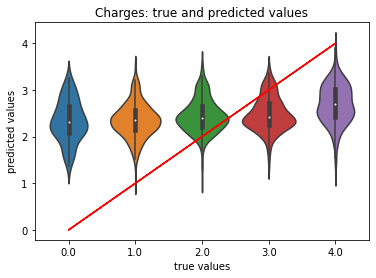

Mean absolute error of the prediction is: 0.9558650477813165
Mean squared error of the prediction is: 1.2625770014562472
Root mean squared error of the prediction is: 1.1236445173880605
Mean absolute percentage error of the prediction is: inf


<IPython.core.display.Javascript object>

In [93]:
#making predictions with our test set.
y_preds = results.predict(X_test)

sns.violinplot(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


Ew that was a total fail.  Let's try a Lasso fit...

In [94]:
grid = {"alpha": [0.1]}

lasso_cv = GridSearchCV(Lasso(), grid, verbose=1, cv=5)
lasso_cv.fit(X_train, y_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {lasso_cv.best_estimator_.alpha}")


coef_df = pd.DataFrame()
coef_df["feat"] = X_train.columns
coef_df["coef"] = lasso_cv.best_estimator_.coef_
coef_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
selected alpha: 0.1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


,feat,coef
0,const,0.000000
1,Gender_2,0.000000
2,Vaccinated_2,-0.000000
3,Dewormed_2,-0.000000
4,FurLength_2,-0.000000
5,FurLength_3,-0.000000
6,Sterilized_2,-0.033552
7,Sterilized_3,0.000000
8,maturity_size_2,0.000000
9,maturity_size_3,-0.000000


<IPython.core.display.Javascript object>

Lastly, let's try paring down the model to a few variables...

In [95]:
# subset
df_lr_2 = df[
    [
        "AdoptionSpeed",
        "Type",
        "age_t",
        "is_pure_bred",
        "has_photo",
        "is_injured",
        "is_black",
    ]
]

X = df_lr_2.drop(columns=["AdoptionSpeed"])
y = df_lr_2["AdoptionSpeed"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

In [96]:
print_vif(X_train)

VIF results
-------------------------------
const           53.886071
Type             1.007859
age_t            1.108497
is_pure_bred     1.104866
has_photo        1.002996
is_injured       1.010060
is_black         1.003741
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [97]:
X_test = sm.add_constant(X_test)
X_train = sm.add_constant(X_train)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<IPython.core.display.Javascript object>

In [98]:
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          AdoptionSpeed   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     168.6
Date:                Sat, 02 May 2020   Prob (F-statistic):          1.26e-206
Time:                        21:19:23   Log-Likelihood:                -18489.
No. Observations:               11994   AIC:                         3.699e+04
Df Residuals:                   11987   BIC:                         3.704e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.4884      0.076     32.831   

<IPython.core.display.Javascript object>

This didn't seem to work so well either...let's switch models

# Modeling - Random Forest with Gradient Boosting

In [99]:
# dropping unnecessary or redundant columns
df_rf = df.drop(
    columns=[
        "Name",
        "Age",
        "Breed1",
        "Breed2",
        # "Color1",
        "Color2",
        "Color3",
        "MaturitySize",
        "Health",
        "Quantity",
        "Fee",
        "fee_t",
        "VideoAmt",
        "PhotoAmt",
        "RescuerID",
        "State",
    ]
)

# categorical variables that need encoding
cat_columns2 = [
    "Gender",
    "Vaccinated",
    "Dewormed",
    "FurLength",
    "Sterilized",
    "maturity_size",
    "1_5_quantity",
    # "State",
    "Color1",
    # "Color2",
    # "Color3",
]

<IPython.core.display.Javascript object>

In [100]:
# one-hot encode the categorical columns
dummy_df2 = one_hot_encode(df_rf, encode_cols=cat_columns2, index=df.index)

# check to make sure it worked...can't be too careful!
dummy_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 33 columns):
Gender_2            14993 non-null float64
Gender_3            14993 non-null float64
Vaccinated_2        14993 non-null float64
Vaccinated_3        14993 non-null float64
Dewormed_2          14993 non-null float64
Dewormed_3          14993 non-null float64
FurLength_2         14993 non-null float64
FurLength_3         14993 non-null float64
Sterilized_2        14993 non-null float64
Sterilized_3        14993 non-null float64
maturity_size_2     14993 non-null float64
maturity_size_3     14993 non-null float64
1_5_quantity_2      14993 non-null float64
1_5_quantity_3      14993 non-null float64
1_5_quantity_4      14993 non-null float64
1_5_quantity_5      14993 non-null float64
Color1_2            14993 non-null float64
Color1_3            14993 non-null float64
Color1_4            14993 non-null float64
Color1_5            14993 non-null float64
Color1_6            14993 non-n

<IPython.core.display.Javascript object>

In [101]:
print_vif(dummy_df2)

VIF results
-------------------------------
const               101.704127
Gender_2              1.225715
Gender_3              2.906564
Vaccinated_2          2.380483
Vaccinated_3          3.774573
Dewormed_2            1.895275
Dewormed_3            3.666136
FurLength_2           1.059639
FurLength_3           1.133694
Sterilized_2          2.074688
Sterilized_3          2.035514
maturity_size_2       1.375377
maturity_size_3       1.355313
1_5_quantity_2        1.437139
1_5_quantity_3        1.480171
1_5_quantity_4        1.495030
1_5_quantity_5        1.772090
Color1_2              1.250143
Color1_3              1.110300
Color1_4              1.079070
Color1_5              1.099380
Color1_6              1.105156
Color1_7              1.080237
Type                  1.298067
AdoptionSpeed         1.135862
has_name              1.095253
age_t                 1.814633
is_pure_bred          1.187170
is_black              1.107359
is_injured            1.028704
is_free               1.06

<IPython.core.display.Javascript object>

In [102]:
X = dummy_df2.drop(columns=["AdoptionSpeed", "Dewormed_3", "Vaccinated_3"])
y = dummy_df2["AdoptionSpeed"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

In [103]:
# fmt: off
pipeline = Pipeline([
    #("encode_cats", LeaveOneOutEncoder()),
    ("gbc", GradientBoostingClassifier())
])
# fmt: on

pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"train_score {train_score}")
print(f"test_score {test_score}")

train_score 0.42954810738702687
test_score 0.3861287095698566


<IPython.core.display.Javascript object>

In [104]:
y_pred = pipeline.predict(X_test)
mean_absolute_error(y_test, y_pred)
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.20      0.02      0.04        82
         1.0       0.32      0.30      0.31       618
         2.0       0.34      0.43      0.38       807
         3.0       0.43      0.12      0.19       652
         4.0       0.46      0.65      0.54       840

    accuracy                           0.39      2999
   macro avg       0.35      0.30      0.29      2999
weighted avg       0.38      0.39      0.36      2999



<IPython.core.display.Javascript object>

Still not great predictive power, but way better than linear regression.  Let's run this model on a grid and find the best hyperparameters possible.

In [ ]:
# Takes a while to run
# grid = {
#     "gbc__subsample": [0.5, 0.75, 1.0],
#     "gbc__max_features": [0.5, 0.75, 1.0],
#     "gbc__max_depth": [5, 7, 9],
# }

# shorter option
grid = {
    "gbc__subsample": [0.25],
    "gbc__max_features": [0.25],
    "gbc__max_depth": [7],
}

n_trees = 100
learning_rate = 2 / n_trees

# fmt: off
pipeline = Pipeline([
#     ("encode_cats", LeaveOneOutEncoder()),
    ("gbc", GradientBoostingClassifier(n_estimators=n_trees, 
                                      learning_rate=learning_rate))
])
# fmt: on

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=7)
pipeline_cv.fit(X_train, y_train)

pipeline_cv.best_params_

Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score {train_score}")
print(f"test_score {test_score}")

A little better with some tuning, but still not great.  Little bit of overfitting going on.  Let's compare these results to a super naive model:

In [ ]:
dummy = DummyClassifier(strategy="uniform")
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

We're doing 19% better than just predicting a uniform distribution.  Let's try to see where the model went wrong.

In [ ]:
y_pred = pipeline_cv.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(
    cm=confusion,
    target_names=["0", "1", "2", "3", "4"],
    title="Confusion Matrix",
    normalize=False,
)

In [ ]:
feat_import = pipeline_cv.best_estimator_["gbc"].feature_importances_
feat_import_df = pd.DataFrame({"feat": X.columns, "importance": feat_import})
feat_import_df = feat_import_df.sort_values("importance", ascending=False)

pred_df = X_test.copy()
pred_df["actual"] = y_test
pred_df["predicted"] = pipeline_cv.predict(X_test)
pred_df["error"] = pred_df["predicted"] - pred_df["actual"]
pred_df["abs_error"] = pred_df["error"].abs()
pred_df = pred_df.sort_values("abs_error", ascending=False)

most_important = list(feat_import_df["feat"].head(6))

display(feat_import_df.head(10))
display(pred_df.head(10))

plt.scatter(pred_df["actual"], pred_df["predicted"])
plt.plot(
    [pred_df["actual"].min(), pred_df["actual"].max()],
    [pred_df["actual"].min(), pred_df["actual"].max()],
)
plt.show()

print(most_important)

important_vars_df = X[most_important]
display(important_vars_df.head(10))
important_vars_df["AdoptionSpeed"] = df["AdoptionSpeed"]
sns.pairplot(important_vars_df)
plt.show()

Not a lot to glean from the mistakes being made.  They don't seem to point to any weakness in the model that can be fixed or tuned.  I think this is just a tough problem to model.  

In future I may want to play around with adding in the photo and decription data.  I peaked at the results of the Kaggle competition and was relieved to see that no one scored above a 45%.  